<a href="https://colab.research.google.com/github/kvamsi7/Deep_Learning/blob/master/CFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Ingestion

Files already downloaded and verified
Files already downloaded and verified


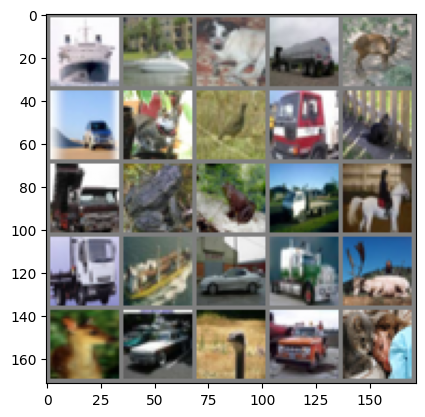

In [15]:
# lets normalize the image
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

# load the dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                             download= True, transform= transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                             download= True, transform= transform)

# Hyper-parameters
num_epochs = 10
batch_size = 32
eta = 0.001

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
  img = img/2 + 0.5 # unnormalize
  # np_img = img.numpy()
  # plt.imshow(np.transpose(np_img,(1,2,0)))
  # or
  plt.imshow(img.permute(1,2,0)) # efficient rather numpy conversion
  plt.show()


# one batch of random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images[:25],nrow = 5, padding= 2)
imshow(img_grid)

## Model Development

### Define Model Architecture

In [19]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size= 3)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
    self.fc1 = nn.Linear(in_features=128*4*4,out_features=64)
    self.fc2 = nn.Linear(in_features=64,out_features=10)

  def forward(self,x):
    out = self.conv1(x)     # dim -> N, 32,30,30
    out = F.relu(out)
    out = self.pool(out)    # dim -> N, 32,15,15
    out = self.conv2(out)   # dim -> N, 64,13,13
    out = F.relu(out)
    out = self.pool(out)    # dim -> N, 64,6,6
    out = self.conv3(out)   # dim -> N, 128,4,4
    out = F.relu(out)
    out = torch.flatten(out,1)   # dim -> N, 2048
    out = self.fc1(out)   # dim -> N, 64
    out = F.relu(out)
    out = self.fc2(out)   # dim -> N, 10
    return out

### Model Creation

In [20]:

cfar10_model = ConvNet().to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cfar10_model.parameters(),lr = eta)

### Model Training

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  running_loss = 0.0

  for i,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # forward
    outputs = cfar10_model(images)
    loss = criterion(outputs,labels)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Epoch [{epoch + 1}] loss: {running_loss/n_total_steps:.3f}')

print("Training Complete")

In [24]:
save_path = 'models/cifar10_model.pth'
torch.save(cfar10_model.state_dict(),save_path)

# Load the Inference the saved model

In [26]:
model = ConvNet()
model.load_state_dict(torch.load(save_path))
model.to(device)

# set eval mode
model.eval()


with torch.no_grad():
  n_correct = 0
  n_correct2 = 0
  n_samples = len(test_loader.dataset)
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = cfar10_model(images)

    _,predicted = torch.max(outputs,1)
    n_correct += (predicted == labels).sum().item()

    outputs2 = model(images)
    _,predicted2 = torch.max(outputs2,1)
    n_correct2 += (predicted2 == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  acc2 = 100.9 * n_correct2 / n_samples
  print(f'Accuracy of the model: {acc} %')
  print(f'Accuracy of the loaded model: {acc2} %')

<ipython-input-26-254283cb34d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Accuracy of the model: 73.24 %
Accuracy of the loaded model: 73.89916000000001 %
